# Naive Classifier for Fake news recognition

## Packages

In [1]:
library(tidyverse)
library(ggplot2)
library(stopwords)
library(tidytext)
library(stringr)
library(purrr)
library(magrittr)

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
── Attaching packages ─────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.4.1     ✔ purrr   1.0.1
✔ tibble  3.2.0     ✔ dplyr   1.1.0
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.4     ✔ forcats 1.0.0

── Conflicts ────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter()  masks stats::filter()
✖ purrr::flatten() masks jsonlite::flatten()
✖ dplyr::lag()     masks stats::lag()


Attaching package: ‘magrittr’


The following object is masked from ‘package:purrr’:

    set_names


The following object is masked from ‘package:tidyr’:

    extract




# Reading the data

### Kaggle dataset

In [2]:
train.filename <- 'dataset/archive/train.csv'
test.filename <- 'dataset/archive/test.csv'

In [3]:
train.df <- read.delim(train.filename, sep = ',')
test.df <- read.delim(test.filename, sep = ',')

### Second dataset

# Display the train and test datasets

In [4]:
head(train.df)

,Labels,Text,Text_Tag
,<int>,<chr>,<chr>
1,1,Says the Annies List political group supports third-trimester abortions on demand.,abortion
2,2,When did the decline of coal start? It started when natural gas took off that started to begin in (President George W.) Bushs administration.,"energy,history,job-accomplishments"
3,3,"Hillary Clinton agrees with John McCain ""by voting to give George Bush the benefit of the doubt on Iran.""",foreign-policy
4,1,Health care reform legislation is likely to mandate free sex change surgeries.,health-care
5,2,The economic turnaround started at the end of my term.,"economy,jobs"
6,5,The Chicago Bears have had more starting quarterbacks in the last 10 years than the total number of tenured (UW) faculty fired during the last two decades.,education


In [5]:
head(test.df)

,Text,Text_Tag
,<chr>,<chr>
1,Building a wall on the U.S.-Mexico border will take literally years.,immigration
2,Wisconsin is on pace to double the number of layoffs this year.,jobs
3,Says John McCain has done nothing to help the vets.,"military,veterans,voting-record"
4,Suzanne Bonamici supports a plan that will cut choice for Medicare Advantage seniors.,"medicare,message-machine-2012,campaign-advertising"
5,"When asked by a reporter whether hes at the center of a criminal scheme to violate campaign laws, Gov. Scott Walker nodded yes.","campaign-finance,legal-issues,campaign-advertising"
6,Over the past five years the federal government has paid out $601 million in retirement and disability benefits to deceased former federal employees.,"federal-budget,pensions,retirement"


# Splitting the datasets

In [6]:
# shuffle
set.seed(29062023)
train.df=train.df[sample(1:nrow(train.df), replace = F),] # shuffle the dataset

In [7]:
# set splitting percentages
perc_split <- 0.8  # set splitting percentages
n_rows <- nrow(train.df)
n_rows_train <- floor(n_rows * perc_split)

In [8]:
# splitting
train.df.train <- train.df[1:n_rows_train, ]
train.df.validation <- train.df[-c(1:n_rows_train), ]

In [9]:
cat('Total rows:',nrow(train.df),
    '\nTrain rows:',nrow(train.df.train),
    '\nValidation rows',nrow(train.df.validation))

Total rows: 10240 
Train rows: 8192 
Validation rows 2048

## Histogram of labels

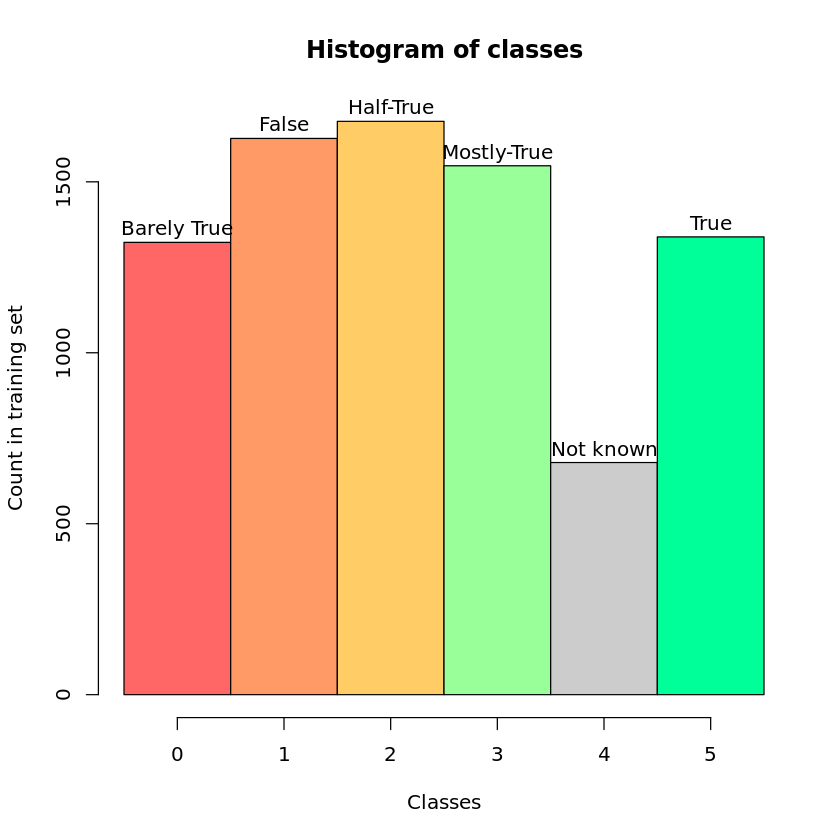

In [10]:
breaks <- seq(from=-0.5, to=5.5, by=1)
labels <- c('Barely True', 'False', 'Half-True', 'Mostly-True', 'Not known', 'True')
colors <- c('#FF6666','#FF9966', '#FFCC66', '#99FF99' , '#CCCCCC','#00FF99')

classes<-hist(x = train.df.train$Labels, 
     breaks = breaks, 
     labels = labels,
     main = 'Histogram of classes',
     xlab = 'Classes',
     ylab = 'Count in training set',
     col = colors
    )

In [11]:
n_classes <- length(labels)

## Defining the prior of each classes

In [12]:
prior.classes<-classes$density

## Stop words

In [13]:
as.list(get_stopwords())$word

[1] "i"          "me"         "my"         "myself"     "we"        
  [6] "our"        "ours"       "ourselves"  "you"        "your"      
 [11] "yours"      "yourself"   "yourselves" "he"         "him"       
 [16] "his"        "himself"    "she"        "her"        "hers"      
 [21] "herself"    "it"         "its"        "itself"     "they"      
 [26] "them"       "their"      "theirs"     "themselves" "what"      
 [31] "which"      "who"        "whom"       "this"       "that"      
 [36] "these"      "those"      "am"         "is"         "are"       
 [41] "was"        "were"       "be"         "been"       "being"     
 [46] "have"       "has"        "had"        "having"     "do"        
 [51] "does"       "did"        "doing"      "would"      "should"    
 [56] "could"      "ought"      "i'm"        "you're"     "he's"      
 [61] "she's"      "it's"       "we're"      "they're"    "i've"      
 [66] "you've"     "we've"      "they've"    "i'd"        "you'd"     
 [71] "he'd"       "she'd"      "we'd"       "they'd"     "i'll"      
 [76] "you'll"     "he'll"      "she'll"     "we'll"      "they'll"   
 [81] "isn't"      "aren't"     "wasn't"     "weren't"    "hasn't"    
 [86] "haven't"    "hadn't"     "doesn't"    "don't"      "didn't"    
 [91] "won't"      "wouldn't"   "shan't"     "shouldn't"  "can't"     
 [96] "cannot"     "couldn't"   "mustn't"    "let's"      "that's"    
[101] "who's"      "what's"     "here's"     "there's"    "when's"    
[106] "where's"    "why's"      "how's"      "a"          "an"        
[111] "the"        "and"        "but"        "if"         "or"        
[116] "because"    "as"         "until"      "while"      "of"        
[121] "at"         "by"         "for"        "with"       "about"     
[126] "against"    "between"    "into"       "through"    "during"    
[131] "before"     "after"      "above"      "below"      "to"        
[136] "from"       "up"         "down"       "in"         "out"       
[141] "on"         "off"        "over"       "under"      "again"     
[146] "further"    "then"       "once"       "here"       "there"     
[151] "when"       "where"      "why"        "how"        "all"       
[156] "any"        "both"       "each"       "few"        "more"      
[161] "most"       "other"      "some"       "such"       "no"        
[166] "nor"        "not"        "only"       "own"        "same"      
[171] "so"         "than"       "too"        "very"       "will"

# Cleaning function

In [14]:
cleaning_tokens <- function(token.df){
    word <- ifelse(endsWith(token.df[,1], "s"), substr(token.df[,1], 1, nchar(token.df[,1]) - 1), token.df[,1])
    word <- ifelse(endsWith(word, "'"), substr(word, 1, nchar(word) - 1), word)
    word <- ifelse(str_detect(word, "[0-9]+"), '--number--', word)
    return(as.data.frame(word))
}

# Vocabulary

In [15]:
tags_numbers <- list(tags = c('Barely True', 'False', 'Half-True', 'Mostly-True', 'Not known', 'True'),
                     numbers = c(0:5))

### Vocabulary before feature selection

In [16]:
vocabulary <- function(train.df.train, tags_numbers){
    #take in input a df with 'Text' column containing the messages and 'tag_numbers' the names of the labels
    
    myframes <- list()

    for (i in 1:length(tags_numbers$tags)) {
        tag <- tags_numbers$tags[i]

        train.df.train %>%
        filter(Labels == tags_numbers$numbers[i]) %>%
        select(Text) %>%
        unnest_tokens(word, Text) %>%
        anti_join(get_stopwords(), by = join_by(word)) %>%
        cleaning_tokens %>%
        arrange(word) %>%
        group_by(word) %>%
        reframe(counts = n()) %>%
        arrange(desc(counts)) %>%
        setNames(c("word", tag)) -> myframes[[i]]
    } 
    counts<-purrr::reduce(myframes, dplyr::full_join, by = 'word')
    counts %<>% replace(is.na(.),0)
    return(counts)
}

## Feature Selection 

## With frequency mean

In [17]:
feature_selection.frequency_mean <- function(counts, n_classes, frac = 0.5) {
    counts %>%
        select(-word) %>%
        colSums() -> tot_counts_per_class

    counts_prob <- cbind(counts["word"], counts[2:(n_classes + 1)]/tot_counts_per_class)
    counts_prob["mean"] <- rowMeans(counts_prob[2:(n_classes + 1)])

    counts_prob %>%
        arrange(desc(mean)) %>%
        top_frac(frac, mean) %>%
        select(word) -> vocabulary.train.features

    counts %>%
        right_join(vocabulary.train.features["word"], by = join_by(word)) -> naive.bayes.vocabulary

    return(naive.bayes.vocabulary)
}

## With absolute counts per class
To implement

# Likelihood computation

In [18]:
likelihood.denominator <- function(naive.bayes.vocabulary) {
    naive.bayes.vocabulary %>%
        select(-word) %>%
        colSums() -> tot_counts_per_class

    den <- tot_counts_per_class + length(naive.bayes.vocabulary[[1]])
    return(den)
}

In [19]:
likelihood <- function(naive.bayes.vocabulary, den) {
    likelihood.token <- cbind(naive.bayes.vocabulary["word"], (naive.bayes.vocabulary[2:(n_classes +
        1)] + 1)/den)
    return(likelihood.token)
}

## Nayve Bayes

In [20]:
bayes.probability <- function(token.list, likelihood.token, prior.classes, den, n_classes) {

    query_out <- log(as.numeric(prior.classes))
    for (i in 1:length(token.list)) {
        query <- log(as.numeric(likelihood.token[likelihood.token["word"] == token.list$word[i]][2:(n_classes+1)]))
        if (is.na(query[1])) {
            query <- as.numeric(log(1/den))
        }
        query_out <- query_out + query
    }
    query_out <- exp(query_out)
    query_out <- query_out/sum(query_out)
    return(query_out)
}

In [21]:
tweet_tokenize <- function(msg) {
    tib <- data.frame(msg)
    colnames(tib) <- "tweet"
    tib %>%
        unnest_tokens(word, tweet) %>%
        anti_join(get_stopwords(), by = join_by(word)) %>%
        cleaning_tokens -> token.list
    return(token.list)
}

In [22]:
naive.bayes <- function(msg, likelihood.token, prior.classes, den, n_classes) {
    token.list <- as.vector(tweet_tokenize(msg))
    probability <- bayes.probability(token.list, likelihood.token, prior.classes,
        den, n_classes)
    predicted_class <- which.max(probability) - 1
    return(predicted_class)
}

In [23]:
# msg<-train.df.validation$Text[1]

# vec<-as.vector(tweet_tokenize(msg))

# bayes.probability(vec, likelihood.token, prior.classes, denominator, n_classes)

# query_out <- log(as.numeric(prior.classes))
# query_out

# for (i in 1:length(vec)) {
#     query <- log(as.numeric(likelihood.token[likelihood.token["word"] == vec$word[i]][2:n_classes +
#         1]))
#     if (is.na(query[1])) {
#         query <- as.numeric(log(1/den))
#     }
#     query_out <- query_out + query
# }

#     query_out <- exp(query_out)
#     query_out <- query_out/sum(query_out)

# msg<-train.df.validation$Text[1]
# naive.bayes(msg, likelihood.token, prior.classes, denominator, n_classes)

# vec<-as.vector(tweet_tokenize(msg))


# log(as.numeric(likelihood.token[likelihood.token["word"] == vec$word[1]][2:(n_classes+1)]))

## Test on validation set

# Run all the functions

In [24]:
# Return data.frame with only counted and tokenized words
counts <- vocabulary(train.df.train, tags_numbers)

In [25]:
fraction <- seq(from = 0.1, to = 1, by = 0.1)

In [ ]:
acc <- vector()
for (i in seq_along(fraction)) {
    # Vocabulary optimized with feature selection
    naive.bayes.vocabulary <- feature_selection.frequency_mean(counts, n_classes,
        frac = fraction[i])

    # Compute denominator of likelihood
    denominator <- likelihood.denominator(naive.bayes.vocabulary)

    # Compute the likelihood for each tokinez and unique word
    likelihood.token <- likelihood(naive.bayes.vocabulary, denominator)

    # Run the prediction
    predicted_classes <- lapply(X = train.df.validation$Text, FUN = naive.bayes,
        likelihood.token = likelihood.token, prior.classes = prior.classes, den = denominator,
        n_classes = n_classes)

    # Check % of right predictions
    acc[i] <- sum(predicted_classes == train.df.validation$Labels)/length(train.df.validation$Labels)
}